In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [2]:
!pip install snapml
!pip install skillsnetwork

In [3]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')

# from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, hinge_loss
import time
import gc, sys
from snapml import DecisionTreeClassifier, SupportVectorMachine

In [4]:
import skillsnetwork
await skillsnetwork.prepare("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0RHPEN/data/creditcard.tgz", overwrite=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Saved to '.'


In [5]:
# Carregamento dos dados
raw_data = pd.read_csv('creditcard.csv')
print(f"Existem {len(raw_data)} observações no conjunto de dados de fraude de cartão de crédito.")
print(f"Existem {len(raw_data.columns)} variáveis no conjunto de dados.")

# Exibição das primeiras linhas do dataset
raw_data.head()

Existem 284807 observações no conjunto de dados de fraude de cartão de crédito.
Existem 31 variáveis no conjunto de dados.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print(f"Existem {len(big_raw_data)} observações no conjunto de dados inflacionado de fraude de cartão de crédito.")
print(f"Existem {len(big_raw_data.columns)} variáveis no conjunto de dados.")

# Exibição das primeiras linhas do novo dataset
big_raw_data.head()

Existem 2848070 observações no conjunto de dados inflacionado de fraude de cartão de crédito.
Existem 31 variáveis no conjunto de dados.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


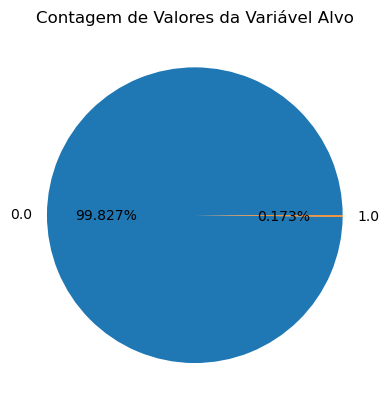

In [7]:
# Obter o conjunto de classes distintas
labels = big_raw_data.Class.unique()

# Obter a contagem de cada classe
sizes = big_raw_data.Class.value_counts().values

# Plotar a contagem de valores da variável alvo
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Contagem de Valores da Variável Alvo')
plt.show()

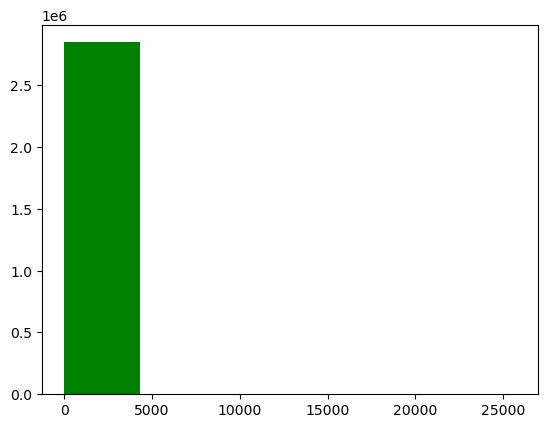

O valor mínimo é  0.0
O valor máximo é  25691.16
O valor mínimo do valor é 90% das transações com valor menor ou igual a  203.0


In [8]:
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("O valor mínimo é ", np.min(big_raw_data.Amount.values))
print("O valor máximo é ", np.max(big_raw_data.Amount.values))
print("O valor mínimo do valor é 90% das transações com valor menor ou igual a ", np.percentile(raw_data.Amount.values, 90))

In [9]:
# Normalizar as variáveis
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

#X: matriz de características (excluindo a variável Time do conjunto de dados)
X = data_matrix[:, 1:30]

# y: vetor de rótulos
y = data_matrix[:, 30]

# Normalização dos dados
X = normalize(X, norm="l1")

# Exibir a forma da matriz de características e do vetor de rótulos
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


In [10]:
# Liberação de memória
del raw_data
del big_raw_data
gc.collect()

3149

In [11]:
# Divisão dos dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


In [12]:
# Cálculo de pesos amostrais balanceados
w_train = compute_sample_weight('balanced', y_train)

In [13]:
# Treinamento do modelo Decision Tree usando Scikit-Learn
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Tempo de treinamento (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Tempo de treinamento (s):  7.16431


In [14]:
# Treinamento do modelo Decision Tree usando Snap ML
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time() - t0
print("[Snap ML] Tempo de treinamento (s):  {0:.5f}".format(snapml_time))

[Snap ML] Tempo de treinamento (s):  3.02049


In [15]:
# Comparação de velocidade de treinamento entre Snap ML e Scikit-Learn
training_speedup = sklearn_time / snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 2.37x 


In [16]:
# Avaliação do modelo Decision Tree
sklearn_pred = sklearn_dt.predict_proba(X_test)[:, 1]
snapml_pred = snapml_dt.predict_proba(X_test)[:, 1]
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] Pontuação ROC-AUC: {0:.3f}'.format(sklearn_roc_auc))

snapml_roc_auc = roc_auc_score(y_test, snapml_pred)
print('[Snap ML] Pontuação ROC-AUC: {0:.3f}'.format(snapml_roc_auc))

[Scikit-Learn] Pontuação ROC-AUC: 0.966
[Snap ML] Pontuação ROC-AUC: 0.966


In [17]:
# Treinamento do modelo SVM usando Scikit-Learn
from sklearn.svm import LinearSVC
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Tempo de treinamento (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Tempo de treinamento (s):  61.37


In [18]:
# Treinamento do modelo SVM usando Snap ML
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
t0 = time.time()
snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Tempo de treinamento (s):  {0:.2f}".format(snapml_time))


[Snap ML] Tempo de treinamento (s):  6.53


In [19]:
# Comparação de velocidade de treinamento entre Snap ML e Scikit-Learn
training_speedup = sklearn_time / snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Support Vector Machine] Snap ML vs. Scikit-Learn speedup : 9.40x 


In [20]:
# Avaliação do modelo SVM
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred = snapml_svm.decision_function(X_test)
acc_sklearn = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] Pontuação ROC-AUC:   {0:.3f}".format(acc_sklearn))

acc_snapml = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] Pontuação ROC-AUC:   {0:.3f}".format(acc_snapml))

[Scikit-Learn] Pontuação ROC-AUC:   0.984
[Snap ML] Pontuação ROC-AUC:   0.985


In [23]:
# Cálculo da perda de hinge
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Perda de Hinge:   {0:.3f}".format(loss_sklearn))

loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Perda de Hinge:   {0:.3f}".format(loss_snapml))

[Scikit-Learn] Perda de Hinge:   0.234
[Snap ML] Perda de Hinge:   0.228
